In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Bigger font
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')
# Figure size®
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 2.5
rcParams['lines.marker'] = '.'
rcParams['lines.linewidth'] = 1
rcParams['lines.markersize'] = 5
rcParams['legend.fontsize'] = 10
rcParams['axes.titlesize'] = 16
# plt.rc('figure.subplot', wspace=.33)
# Slides
from notebook.services.config import ConfigManager
cm = ConfigManager()
# cm.update('livereveal', {'width': 1024, 'height': 768, 'scroll': True, 'theme': 'simple', 'transition': 'linear'});
# np.random.seed(123)
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"  # print not only the last variable
%config InlineBackend.figure_format ='retina'  # retine quality plots

Reinforcement learning problems include the goal of defining a **control policy**.

## Mountain Car Simulator

- **Objective:** Climb the mountain and reach the flag.

- Possible actions: left, stop, right
- Optimal control policy: Sequence of actions that makes the car reach the flag after $T$ steps (these steps will be states).

In [4]:
import gym
env = gym.make("MountainCarContinuous-v0")

## States

At each time step $t$, the car is characterized by its POSITION and its VELOCITY at time $t$.

$$
\mathbf{s}_{t}=\left(p_{t}, v_{t}\right)
$$

## Dynamics of the car

$$
\mathbf{s}_{t+1}=f\left(\mathbf{x}_{t}, \mathbf{a}_{t}\right)
$$

where $u_t$ is the action (which can be **left, stop, right**)

## Policy 

The actions come from a policy

$$
\mathbf{a}_{t}=\pi\left(\mathbf{s}_{t}, \theta\right)
$$

where $t=\{1,\dots,T\}$. The parameter $\theta$ is part of the policy model that's assumed to be linear

$$
\pi(\mathbf{s},\theta)= \theta_p p + \theta_vv.
$$

In [5]:
def model(state, theta):
    model_action = (np.dot(theta, state))
    return [model_action]

In [6]:
state = np.array([3, 0])
theta = np.array([0.5, 0.5])
model(state, theta)

[1.5]

In [7]:
# Optimal [-3.31744142, 9.81281166]

## Episodes

They will be defined as having length $T$.

**Reward after T states:** $R_{T}(\theta)$ 

## Reward

Reward for reaching the flag: 100 - squared sum of actions (a real negative to push to the left and a real positive to push to the right)


## Optimization Problem

$$
\theta^* = arg \max_{\theta} R_T(\theta)
$$

In [8]:
import GPyOpt

TIME_LIMIT = 400

def run_simulation(env, theta, trace=True, render=False):
    theta = theta[0]
    env.seed(0)
    observation = env.reset()
    
    state = []
    action = []
    frames = []
    cumulative_reward = 0
    for i in range(0, TIME_LIMIT):
        # Calculate the action
        model_action = model(observation, theta)
        
        # Save current state + action
        state.append(observation)
        action.append(model_action)
        # Execute action
        observation, reward, done, info = env.step(model_action)
        if render:
            frames.append(env.render(mode='rgb_array'))
            
        cumulative_reward += reward
        if done:
            state.append(observation)
            break
    if trace:
        print("Cumulative Reward:", cumulative_reward, "$theta:",theta)
    return cumulative_reward, state, action, frames


In [9]:
domain= [{'name':'position_parameter', 'type':'continuous', 'domain':(-10, 10)},
         {'name':'velocity_parameter', 'type':'continuous', 'domain':(-10, 10)},
         ]

f = lambda theta: run_simulation(env, theta, False)[0]  # output the cost

from GPyOpt.methods import BayesianOptimization
optimizer = BayesianOptimization(f=f, domain=domain, model_type='GP', acquisition_type ='EI',
                                 exact_feval=True, initial_design_numdata=1)
optimizer.run_optimization(max_iter=100)

In [10]:
a, b = optimizer.get_evaluations()
print('a', a)
print('b', b)
best_index = np.argmax(b)
best_x = np.reshape(a[best_index], (1, -1))
best_y = b[best_index]
print("Best parameters:", best_x, "Cum. Reward:",best_y)

a [[  7.26516311   2.59924339]
 [  5.93811665   3.53643389]
 [  7.36444723   2.53880422]
 [  8.45980861   1.8231058 ]
 [ 10.          -6.67860906]
 [ 10.          -3.09187387]
 [-10.         -10.        ]
 [ 10.         -10.        ]
 [ 10.          10.        ]
 [-10.          10.        ]
 [ 10.           7.31165525]
 [ 10.           8.70229446]
 [ 10.          -4.78176795]
 [ 10.           4.16192755]
 [ 10.           5.59978358]
 [ -9.95008771   0.49816519]
 [  9.98639849   1.91373318]
 [  9.95361623  -9.1329246 ]
 [  9.97393558  -1.63753623]
 [  9.9840507    9.36626005]
 [ -1.00350275  -9.92110287]
 [  9.94329218  -0.48790009]
 [  9.98844268  -9.35872453]
 [  9.99231483   2.98790181]
 [  9.98907054   8.22609376]
 [  9.99052468   6.12784784]
 [  9.99967041   8.02319742]
 [  9.99335202  -4.89775638]
 [  9.96374498  -7.68257135]
 [  9.9878058   -4.63978019]
 [  9.98175253  -5.5866628 ]
 [  9.97583903   8.79405095]
 [  9.98827567   4.62944692]
 [  9.99520951   8.52368761]
 [ -3.911685

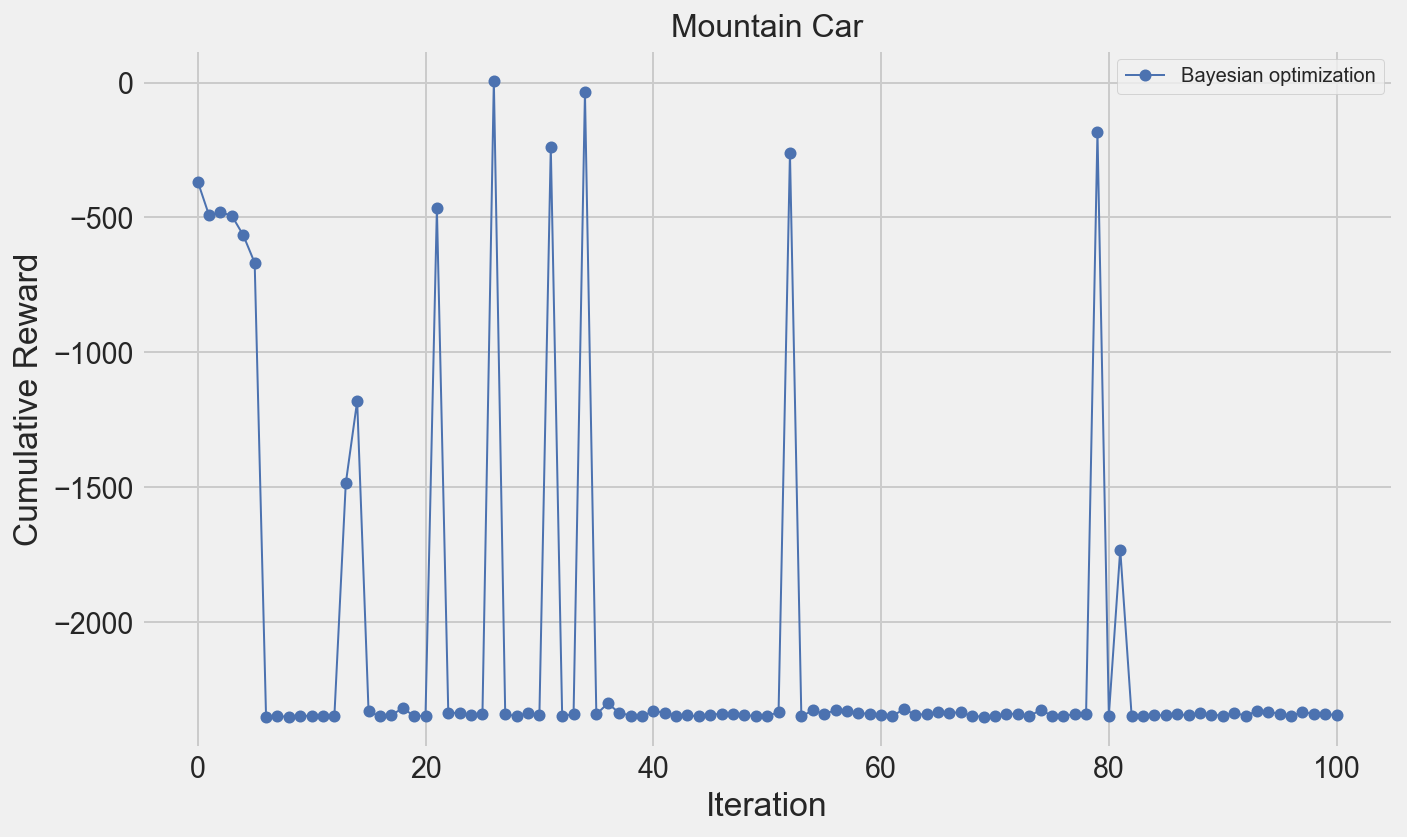

In [35]:
f = plt.figure(figsize=(10, 6))
plt.plot(optimizer.Y, 'bo-', label='Bayesian optimization');
plt.xlabel('Iteration');
plt.ylabel('Cumulative Reward');
plt.title('Mountain Car');
plt.legend();
# f.savefig("boiterations.pdf", bbox_inches='tight');

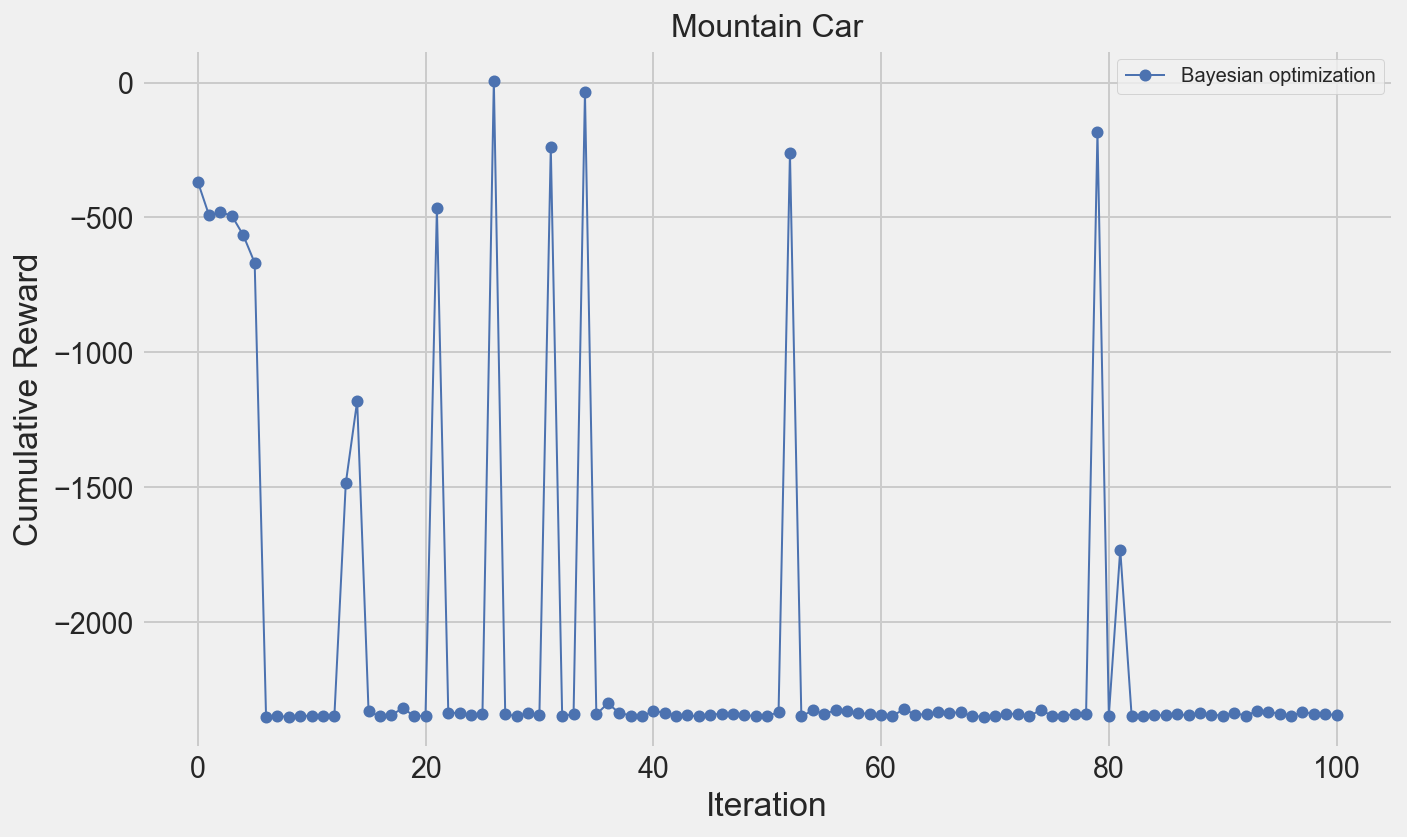

In [36]:
f = plt.figure(figsize=(10, 6));
plt.plot(optimizer.Y, 'bo-', label='Bayesian optimization');
plt.xlabel('Iteration');
plt.ylabel('Cumulative Reward');
# plt.ylim((-10000,10000));
plt.title('Mountain Car');
plt.legend();
# f.savefig("boiterations.pdf", bbox_inches='tight');

<Figure size 720x180 with 0 Axes>

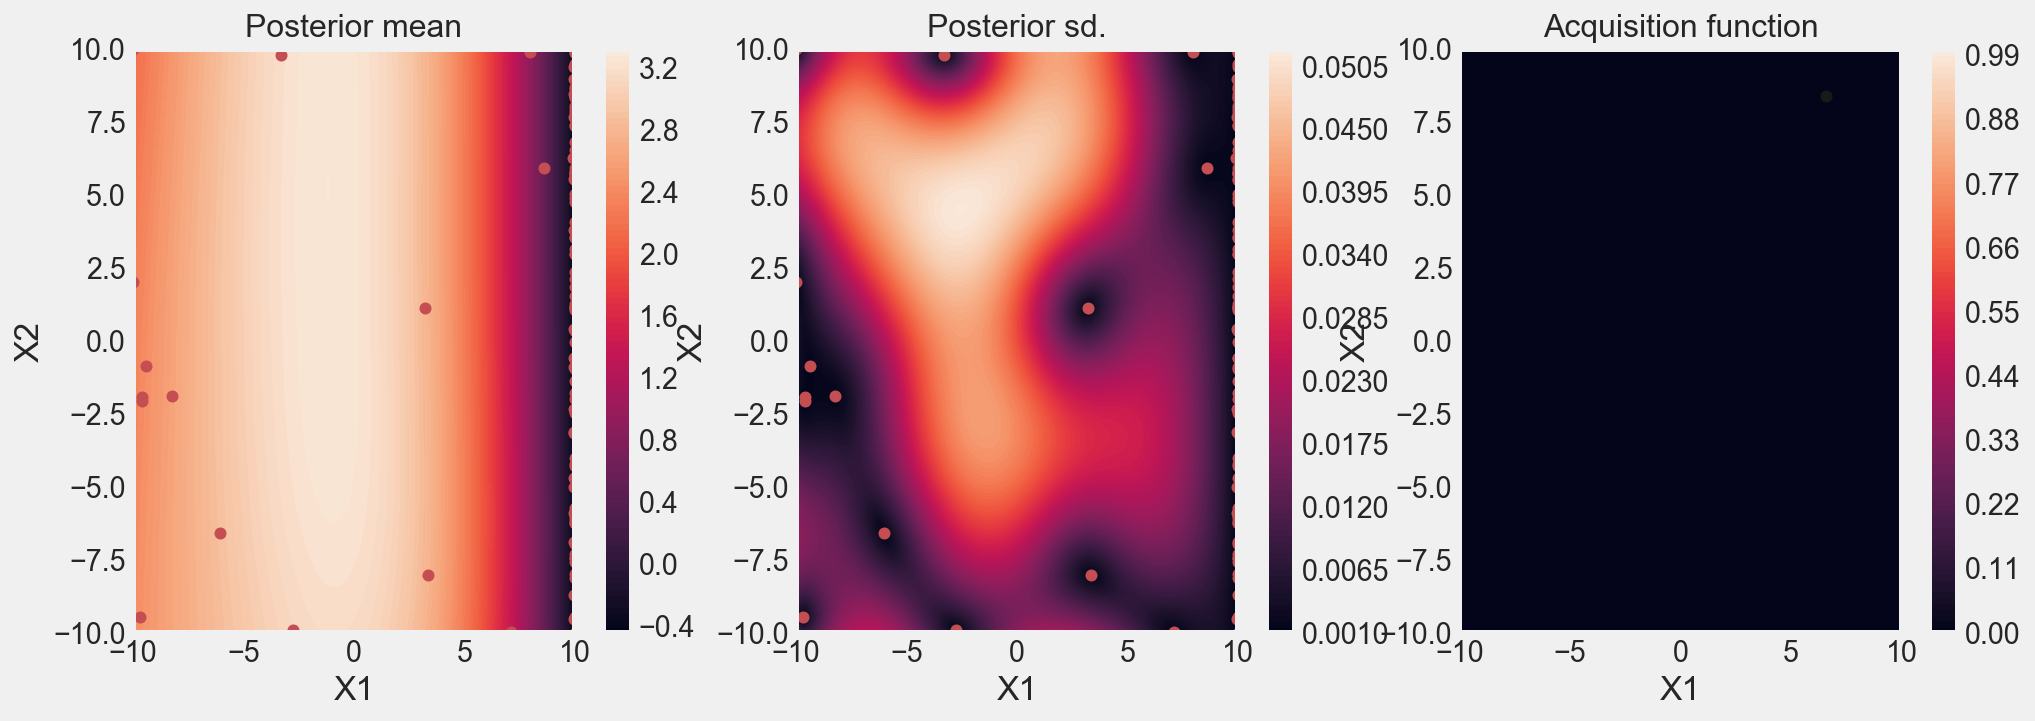

In [37]:
f = plt.figure()
optimizer.plot_acquisition # TODO
# f.savefig("boheat.pdf", bbox_inches='tight')

## Full function

```
Observation      Min	Max
Car Position	-1.2    0.6
Car Velocity    -0.07   0.07
```

## Best Policy

In [40]:
run_simulation(env, best_x, True, True);
env.close()

Cumulative Reward: 7.378780608119186 $theta: [-3.31744142  9.81281166]


In [39]:
best_x

array([[-3.31744142,  9.81281166]])